<center>
<table style="border:none">
    <tr style="border:none">
    <th style="border:none">
        <a  href='https://colab.research.google.com/github/AmirMardan/ml_course/blob/main/7_fully_connected_nn/1_simpe_NN_with_pytorch.ipynb'><img src='https://colab.research.google.com/assets/colab-badge.svg'></a>
    </th>
    <th style="border:none">
        <a  href='https://github1s.com/AmirMardan/ml_course/blob/main/7_fully_connected_nn/1_simpe_NN_with_pytorch.ipynb'><img src='../imgs/open_vscode.svg' height=20px width=115px></a>
    </th>
    </tr>
</table>
</center>


This notebook is created by <a href='https://amirmardan.github.io/'> Amir Mardan</a>. For any feedback or suggestion, please contact me via <a href="mailto:mardan.amir.h@gmail.com">email</a>, (mardan.amir.h@gmail.com).



<a name='top'></a>
# A Simple Neural Network with PyTorch

In this notebook, we create a very simple linear regression using PyTorch to predict the value of houses in an available dataset.

This notebook will cover the following topics:

- [1. Data Loading](#data_loading)
- [2 . Data Preprocessing](#cleaning)
- [3. Network Designing](#network)
- [4. Network Initialization and Hyperparameters](#hyper_parameters)
- [5. Training](#Train)
- [6. Loss Visualization](#loss)
    

<a name='data_loading'></a>
## 1. Data Loading

In [1]:
import pandas as pd

url = (r'https://raw.githubusercontent.com/AmirMardan/ml_course/main/data/cal_housing.csv')
df = pd.read_csv(url)


df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<a name='cleaning'></a>
## 2. Data Preprocessing

We first separate the training and validation data

In [2]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df,
                                       test_size=0.1,
                                       shuffle=True,
                                       random_state=1)



We separate the label (house value) from the features for both training and validation sets.

In [3]:
train_label = train_set['median_house_value']

train_set.drop(columns='median_house_value', 
                           inplace=True)

test_label = test_set['median_house_value']

test_set.drop(columns='median_house_value', 
                           inplace=True)

train_num = train_set.select_dtypes(['float64'])
train_cat = train_set.select_dtypes(['object'])

We create imputer for both numerical and categorical data to preprocess them.

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_features = list(train_num)
cat_features = list(train_cat)

num_pipeline = Pipeline([ 
                         ('imputer', SimpleImputer(strategy='median')),
                         ('std_scaler', StandardScaler()),
                         ])


cat_pipeline = Pipeline([ 
                         ('encoder', OneHotEncoder(sparse=False))
                         ])


final_pipeline = ColumnTransformer([
                ('num', num_pipeline, num_features),
                ('cat', cat_pipeline, cat_features)
                         ])

final_pipeline.fit(train_set)
processed_training_data = final_pipeline.transform(train_set)

processed_training_data.shape


/Users/amir/repos/venv/AI/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(18576, 13)

Now, it is time to create our neural network model.

In [5]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt


<a name='network'></a>
## 3. Network Designing

The used network is actually a linear regression model.
So, we use module `nn.Linear` to create this model.

In [6]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear0 = nn.Linear(input_size, output_size)
        
        
    def forward(self, x):
        x = self.linear0(x)
        return x

Here we convert the datasets to PyTorch tensor.

In [7]:
X = torch.tensor(processed_training_data.astype(np.float32))
y = torch.tensor(train_label.to_numpy(np.float32).reshape(-1, 1))

print(X.shape, y.shape)

torch.Size([18576, 13]) torch.Size([18576, 1])


We create the linear regression object and define the desired loss function which is mean squared error.
```Python
mse = nn.MSELoss()
```
To minimize this loss, we need an optimization algorithm. 
For this notebook, I used stochastic gradient descent as
```Python
optimizer = torch.optim.SGD(lin_model.parameters(), lr=learning_rate)
```
which gets the trainable parameters (`lin_model.parameters()`) and defined learning rate.


<a name='hyper_parameters'></a>
## 4. Network Initialization and Hyperparameters

In [8]:
input_size = processed_training_data.shape[1]
output_size = 1

lin_model = LinearRegression(input_size, output_size)

mse = nn.MSELoss()

learning_rate = 0.02
optimizer = torch.optim.SGD(lin_model.parameters(), lr=learning_rate)

iteration_number = 501

<a name='Train'></a>
## 5. Training

In the next step, we can train the network through an iterative procedure where the trainable parameters get adjusted in each iteration to minimize the loss.

In [9]:
loss_list = []



for iteration in range(iteration_number):
    optimizer.zero_grad()
    
    results= lin_model(X)
    
    loss = mse(results, y)
    
    loss.backward()
    
    optimizer.step()
    
    loss_list.append(np.sqrt(loss.data))
    
    if (iteration % 50 == 0):
        print(f'Epoch {iteration}, loss {np.sqrt(loss.data)}')

Epoch 0, loss 237133.375
Epoch 50, loss 77233.546875
Epoch 100, loss 72246.59375
Epoch 150, loss 70687.875
Epoch 200, loss 69894.9921875
Epoch 250, loss 69477.046875
Epoch 300, loss 69248.5546875
Epoch 350, loss 69117.140625
Epoch 400, loss 69036.59375
Epoch 450, loss 68983.6640625
Epoch 500, loss 68946.4375


<a name='loss'></a>
## 5. Loss Visualization

Let's visualize the loss by plotting the convergence curve.

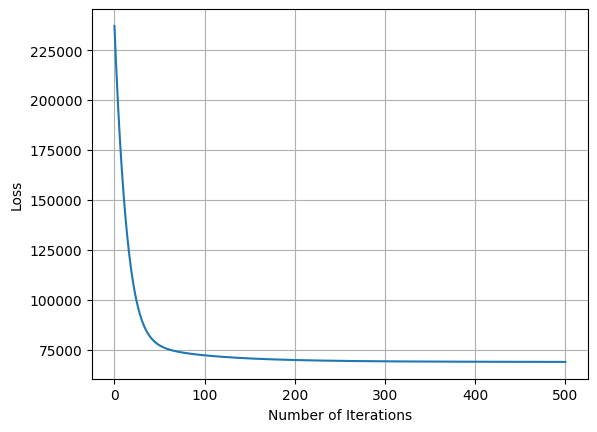

In [10]:
plt.plot(range(iteration_number),loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()

As is shown, the final loss is still large, but the network has converged.
For now, the network can predict the price with 75000 error!!
So, further studies are required to increase the accuracy of the results.
To increase the  accuracy more accurate data preprocessing is required.
More complex network and adding more training data can also helps.

### [TOP ☝️](#top)
